<a href="https://colab.research.google.com/github/ajitjadhav10/Mix_Marketing_Modeling/blob/main/Media_Mix_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title: Media Mix Modeling for budget optimization

- The aim of the project is to optimize media budget allocation.
- Data set used for this project is acquired from: https://github.com/sibylhe
- In this project I've used Google's Lightweight MMM package for the modeling process.

### Installing the required libraries

In [ ]:
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.8.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.1 which is incompatible.


### Importing the required libraries

In [ ]:
import jax.numpy as jnp
import numpyro
import pandas as pd

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

### Importing the dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ajitjadhav10/Mix_Marketing_Modeling/main/data.csv")
df.head()

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0


### Consolidating only the required columns

- For this media mix model, I'll be using the media variables (money spent on different media channels), control variables and the seasonality variables.
- The target variable is the sales (revenue generated through different media channels).

In [ ]:
# media variables
# extracting required media spending columns
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# control variables
# holiday variables and seasonality variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
seas_cols = [col for col in df.columns if 'seas_' in col]
control_vars =  hldy_cols + seas_cols

#  target variable (sales variables)
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]

#renaming the columns
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]

In [ ]:
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
SEED = 105

data_size = len(df_main)
n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

### Splitting the dataset into train and test set

In [ ]:
# Splitting and scaling the dataset .

test_data_period_size = 24 # using the last 24 weeks of data for testing
split_point = data_size - test_data_period_size

# Media variables

media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features (control variables and seasonality)
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

### Scaling the data

- Data in each column is scaled so that each one of it contributes equally to model, this ensures that one feature does not have a dominating influence on the model because of its scale. For eg. if 10x money is spent on social media in comparison to sms marketing, then it'll make the model think that the social media is more important than sms marketing without even comparing its effectiveness.

- So scaling is done to ensure that the model is not biased and the data is more comparable.

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

### Model Training

It is likely that the effect of a media channel on sales could have a lagged effect which tapers off slowly over time.

The Lightweight MMM model captures this effect and offers three different approaches. The approach that works the best will typically be the one which has the best out-of-sample fit (which is one of the generated outputs).

The 3 approaches are:

- Adstock: Applies an infinite lag that decreases its weight as time passes.

- Hill-Adstock: Applies a sigmoid like function for diminishing returns to the output of the adstock function.

- Carryover: Applies a causal convolution giving more weight to the near values than distant ones.

**For this project I've used the Hill-Adstock approach after testing all three approaches as the Hill-Adstock approach offered the best out of sample fit.**

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [ ]:
number_warmup=1000
number_samples=1000

In [ ]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = mdsp_cols,
    seed=SEED)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:359: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [02:58<00:00, 11.19it/s, 1023 steps of size 1.84e-03. acc. prob=0.92]


In [ ]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.04      0.84      0.06     -1.28      1.43    349.67      1.00
             coef_extra_features[1]      0.11      0.71      0.14     -1.06      1.21    256.52      1.00
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.03     -0.00    309.86      1.02
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01    689.96      1.00
             coef_extra_features[4]     -0.06      0.71     -0.06     -1.29      1.07    298.54      1.00
             coef_extra_features[5]     -0.10      0.71     -0.12     -1.21      1.06    256.82      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00   1246.30      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00    856.88      1.00
             coef_extra_features[8]     -0.02

### Visualizing the posterior distributions of the media effects

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7a26d4dbe950>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in fu

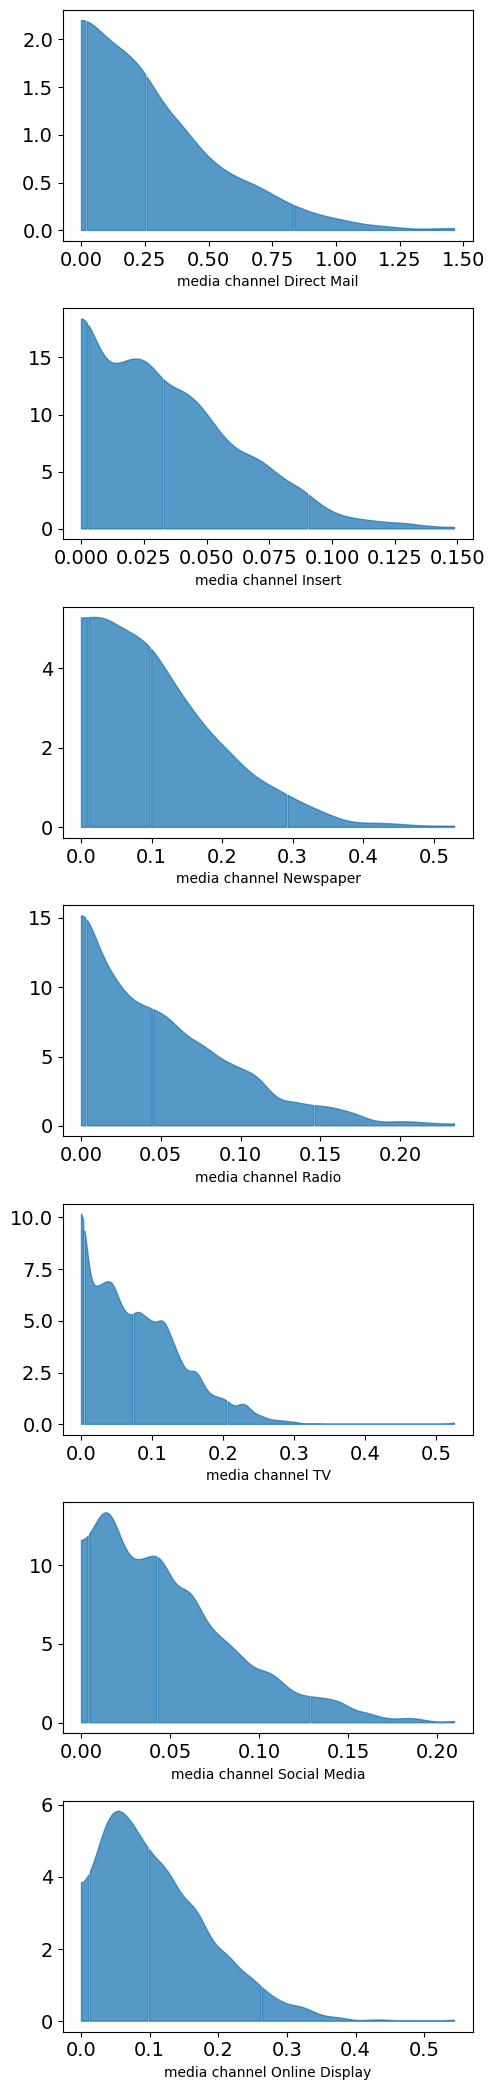

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

In [ ]:
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)

### Plotting the true KPI and the predicted KPI (not scaled)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


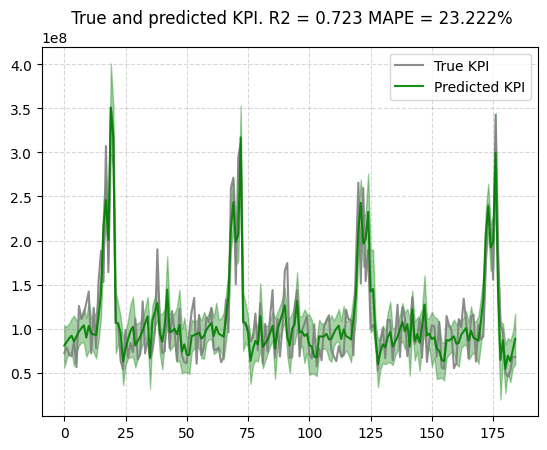

In [ ]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

### Plotting the true KPI and the predicted KPI (scaled)

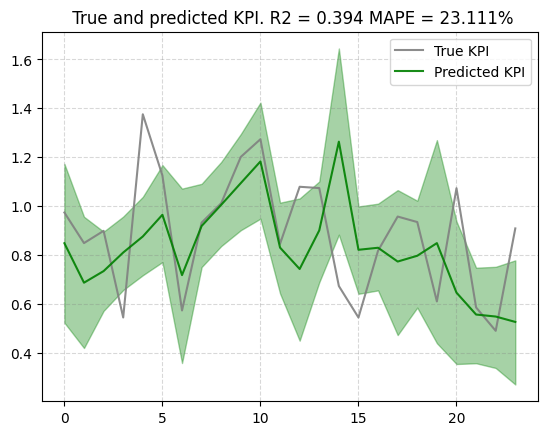

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

## Media Insights

In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

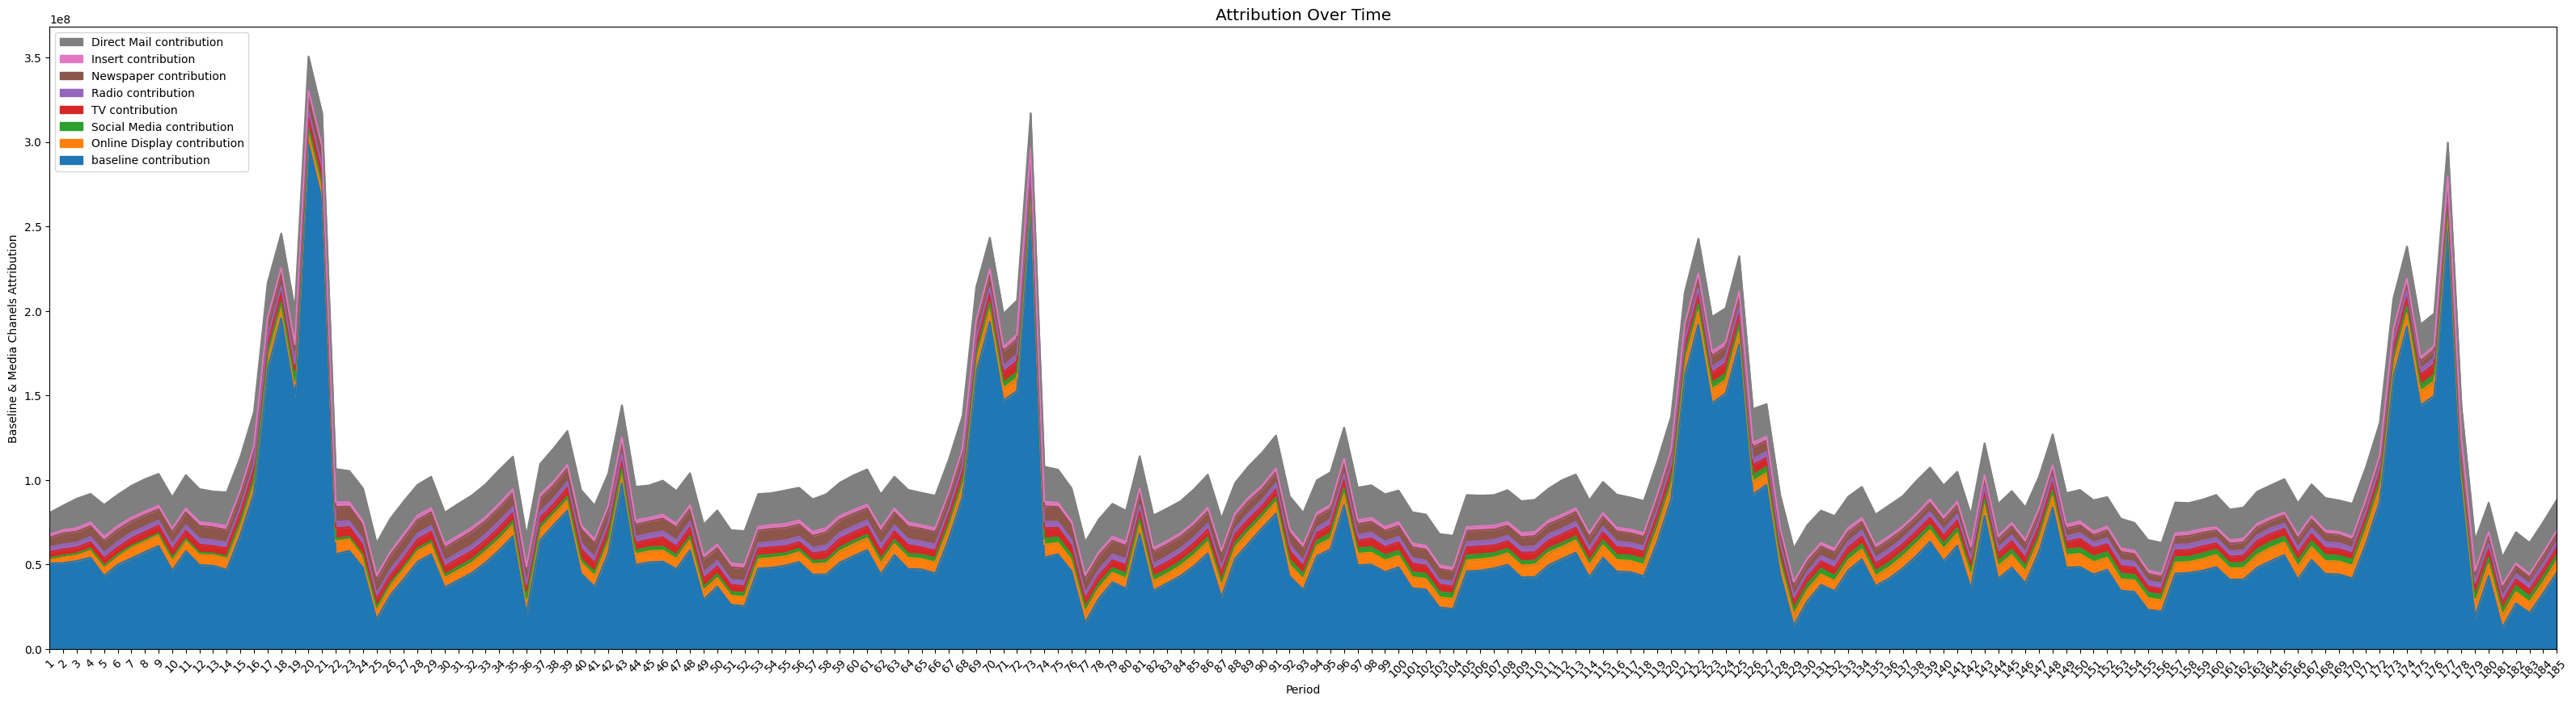

In [ ]:
›plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm, target_scaler=target_scaler, fig_size=(40,10), channel_names = mdsp_cols)

###  Estimated media contributions with their respective credibility intervals

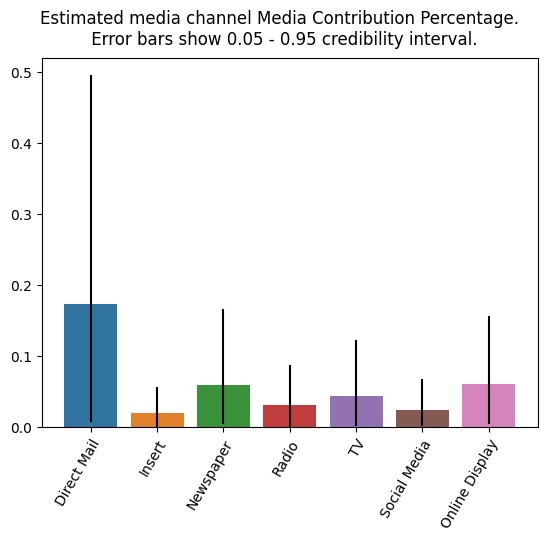

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=mdsp_cols)

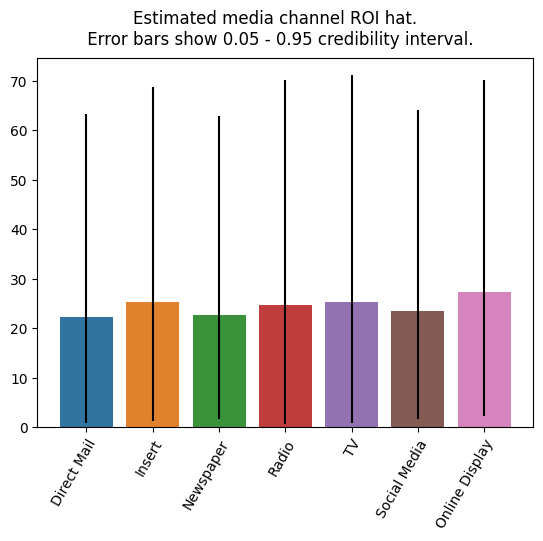

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

### Analyzing behavior of media channels when more money is invested in it

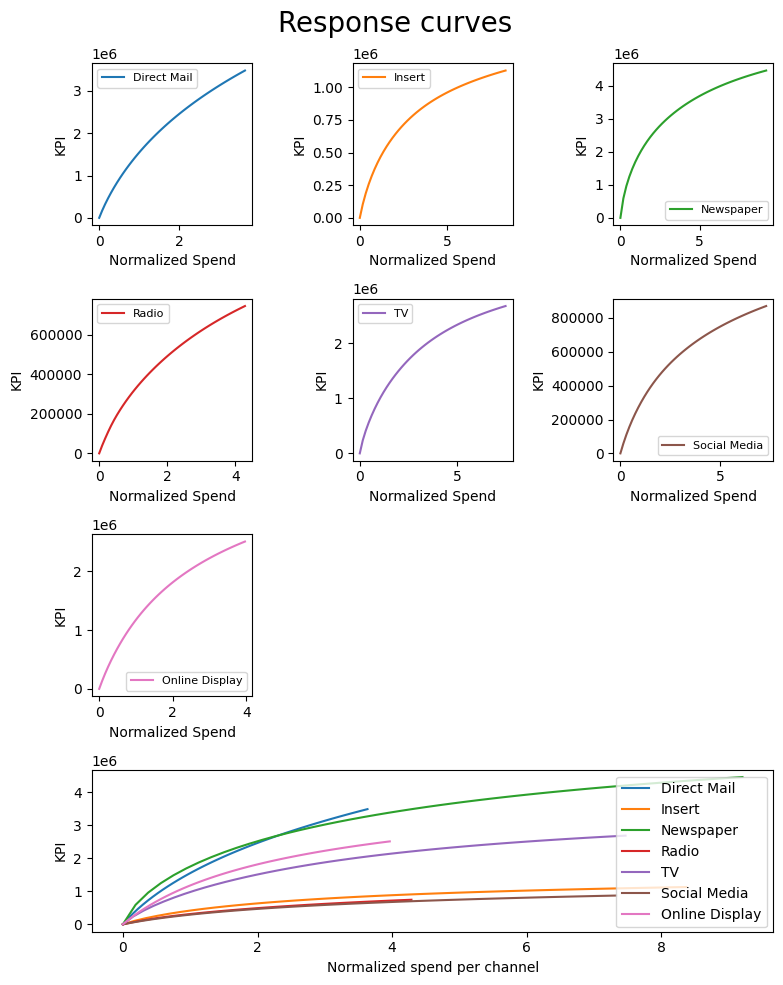

In [ ]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Budget Optimization

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

In [ ]:
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [ ]:
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2030963437.443738
            Iterations: 130
            Function evaluations: 2588
            Gradient evaluations: 129


In [ ]:
# Optimized weekly budget allocation

optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([12732954. ,  1919056.8,  5685350.5,  2121707.8,  4242602.5,
        2253508.5,  5053708. ], dtype=float32)

In [ ]:
# Previous budget allocation

previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([15288896. ,  1625417.5,  5506312.5,  2342750.2,  3396159.2,
        1803910.1,  4045440.8], dtype=float32)

In [ ]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

In [ ]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

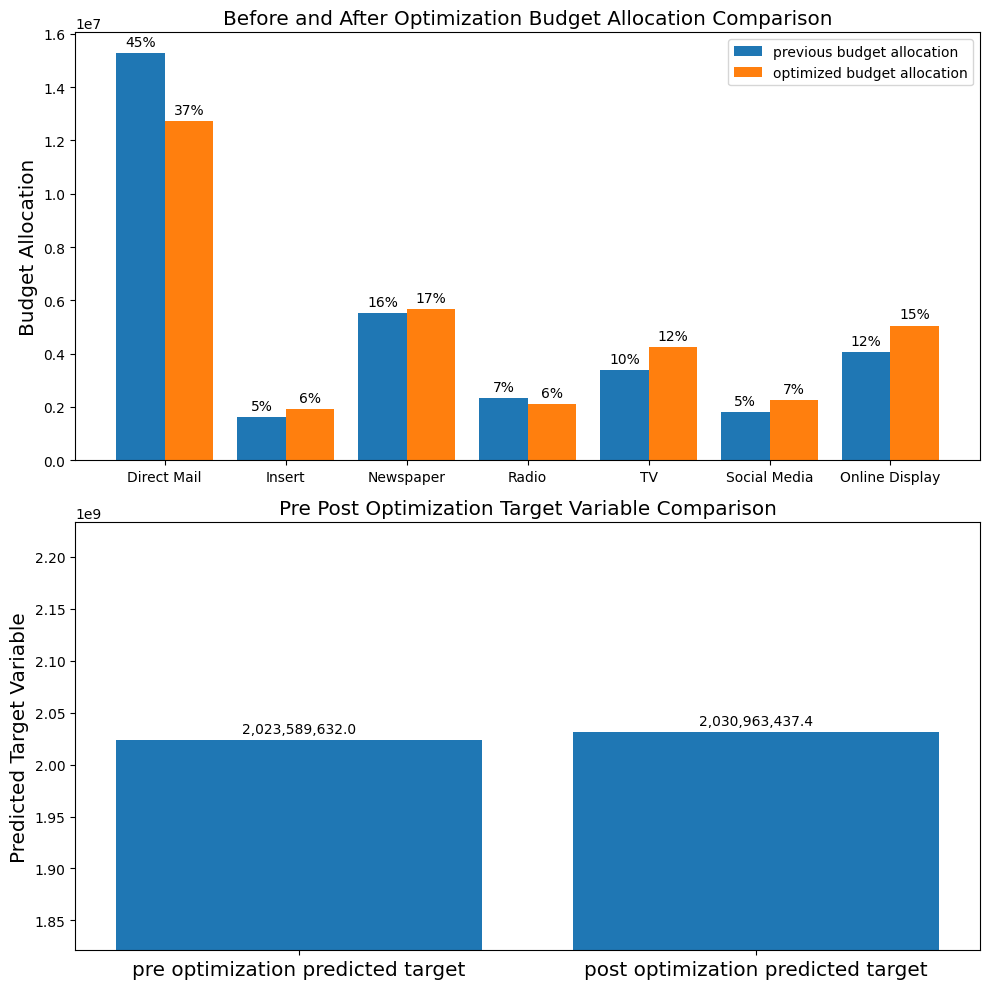

In [ ]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10),
                                                channel_names = mdsp_cols)